# Комп’ютерний практикум 1. Навчання регресiйної моделi методами градiєнтного спуску в TensorFlow2

Варіант 5. Полiномiальна регресiя, алгоритм градiєнтного спуску за мiнi-батчами, MSE з регуляризацiєю за нормою L2.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [47]:
X_data = np.linspace(-1, 1 , 100 )
num_coef=3
coef =[-10, 2, 3]
y_data=0
for i in range(num_coef):
    y_data += coef[i] * np.power(X_data, i)
y_data += np.random.randn(*X_data.shape) * 1.5

In [48]:
infy_stock_df = pd.read_csv('./content/kaggle/infy_stock.csv', index_col=0)
infy_stock_df.head(5)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.9,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.0,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.5,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.1,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.0,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270


In [49]:
infy_stock_df = infy_stock_df.filter(items=['Prev Close', 'Open', 'Turnover', 'Close'])
infy_stock_df.head(5)

,Prev Close,Open,Turnover,Close
Date,,,,
2015-01-01,1972.55,1968.95,9.870306e+13,1974.40
2015-01-02,1974.40,1972.00,3.394669e+14,2013.20
2015-01-05,2013.20,2009.90,4.979911e+14,1995.90
2015-01-06,1995.90,1980.00,4.724458e+14,1954.20
2015-01-07,1954.20,1965.00,3.557162e+14,1963.55


## Графічне представлення даних

### (a)

/var/folders/88/94zrcllx065_b23pbtd8g1040000gn/T/ipykernel_25306/1859033084.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


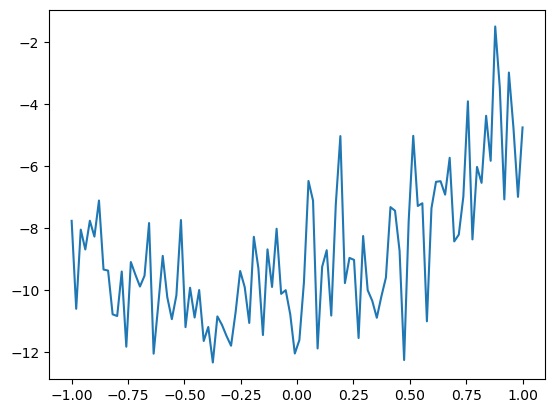

In [50]:
fig, ax = plt.subplots()
ax.plot(X_data, y_data)
fig.show()

### (b)

<Axes: xlabel='Date'>

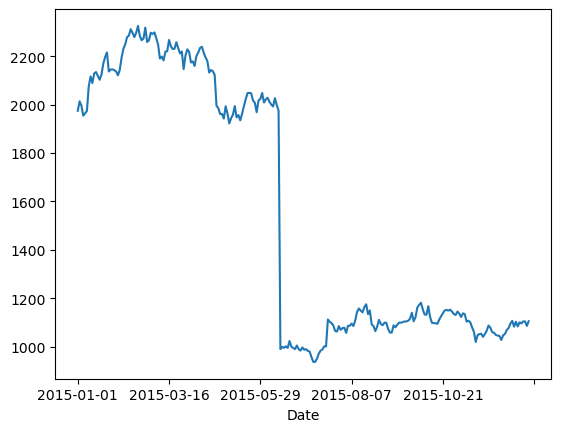

In [51]:
infy_stock_df['Close'].plot()

## Створити власну модель

In [52]:
class PolynomialRegression(tf.keras.Model):
    def __init__(self, degree, l2, **kwargs):
        super(PolynomialRegression, self).__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(l2))
        self.degree = degree
        
    def call(self, inputs):
        x = inputs
        for d in range(self.degree + 1):
          x = tf.concat([x, tf.pow(inputs, d)], axis=1)   
        return self.dense(x)
      
    def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data

      with tf.GradientTape() as tape:
          y_pred = self(x, training=True)  # Forward pass
          # Compute the loss value
          # (the loss function is configured in `compile()`)
          loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

      # Compute gradients
      
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))
      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)
      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}

## Навчання та збереження моделі, обробка результатів

In [53]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp: kt.HyperParameters):
    model = PolynomialRegression(degree=hp.Int("degree", min_value=1, max_value=5, step=1), l2=hp.Float('l2', min_value=0, max_value=1, step=0.01))
    model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=hp.Float(
      "learning_rate",
      min_value=0.0001,
      max_value=0.1,
      step=10,
      sampling="log")), loss="mse", metrics=["mape"])
    return model
    
  def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )


### (a)

Налаштування параметрів

In [54]:
tuner = kt.BayesianOptimization(
    MyHyperModel(),
    objective="loss",
    max_trials=25,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)

In [55]:

tuner.search(x=tf.expand_dims(X_data, axis=-1), y=y_data, epochs=100)


Trial 25 Complete [00h 00m 01s]
loss: 44.97173309326172

Best loss So Far: 2.3333823680877686
Total elapsed time: 00h 00m 21s
INFO:tensorflow:Oracle triggered exit


In [56]:
tuner.results_summary(num_trials=25)

Results summary
Results in my_dir/tune_hypermodel
Showing 25 best trials
Objective(name="loss", direction="min")

Trial 14 summary
Hyperparameters:
degree: 5
l2: 0.0
learning_rate: 0.1
batch_size: 128
Score: 2.3333823680877686

Trial 17 summary
Hyperparameters:
degree: 5
l2: 0.0
learning_rate: 0.1
batch_size: 16
Score: 2.3513312339782715

Trial 12 summary
Hyperparameters:
degree: 3
l2: 0.05
learning_rate: 0.1
batch_size: 16
Score: 2.886206865310669

Trial 15 summary
Hyperparameters:
degree: 1
l2: 0.0
learning_rate: 0.1
batch_size: 128
Score: 3.5353667736053467

Trial 22 summary
Hyperparameters:
degree: 1
l2: 0.0
learning_rate: 0.1
batch_size: 16
Score: 3.580143690109253

Trial 21 summary
Hyperparameters:
degree: 5
l2: 0.48
learning_rate: 0.1
batch_size: 128
Score: 3.8100571632385254

Trial 23 summary
Hyperparameters:
degree: 5
l2: 0.48
learning_rate: 0.1
batch_size: 16
Score: 3.850653886795044

Trial 09 summary
Hyperparameters:
degree: 4
l2: 0.49
learning_rate: 0.01
batch_size: 16
Scor

In [57]:
model = PolynomialRegression(degree=5, l2=0)
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.1), loss="mse", metrics=["mape"])
history = model.fit(tf.expand_dims(X_data, axis=-1), y_data, epochs=100, batch_size=16)

Epoch 1/100
7/7 [==============================] - 0s 621us/step - loss: 26.2548 - mape: 45.7834
Epoch 2/100
7/7 [==============================] - 0s 503us/step - loss: 4.6331 - mape: 27.2073
Epoch 3/100
7/7 [==============================] - 0s 529us/step - loss: 3.6474 - mape: 23.6094
Epoch 4/100
7/7 [==============================] - 0s 521us/step - loss: 3.1969 - mape: 20.3928
Epoch 5/100
7/7 [==============================] - 0s 446us/step - loss: 2.9533 - mape: 20.7022
Epoch 6/100
7/7 [==============================] - 0s 414us/step - loss: 2.8022 - mape: 19.8872

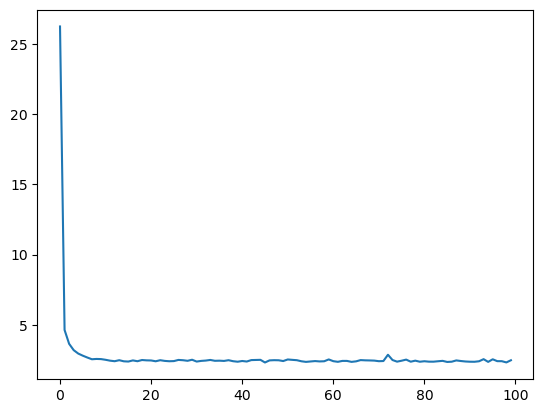

In [58]:
plt.plot(history.history['loss'])

Збереження моделі та завантаження нової

In [59]:
def save_my_model(model, path):
  tf.saved_model.save(model, path)
  print("Model was saved")

def save_weigts_model(model, path):
  model.save_weights(path + '.h5')
  print('Weigts saved!')

In [60]:
json_config = model.to_json()
model.save_weights("weights")

Графiк з початковими даними та лiнiєю регресiї.

In [61]:
y_pred = model.predict(tf.expand_dims(X_data, axis=-1), batch_size=16)

7/7 [==============================] - 0s 480us/step


/var/folders/88/94zrcllx065_b23pbtd8g1040000gn/T/ipykernel_25306/3626724574.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


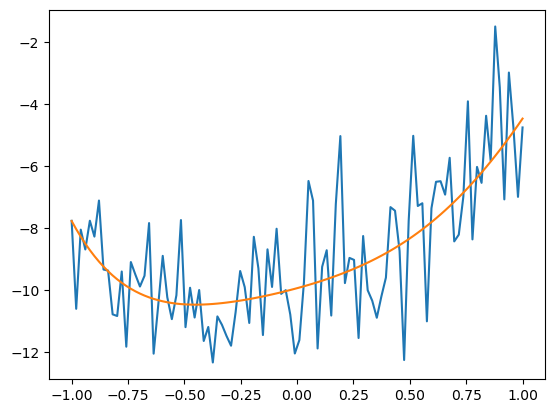

In [62]:
fig, ax = plt.subplots()
ax.plot(X_data, y_data, X_data, y_pred)
fig.show()

### (b)

In [63]:
# Fit the scaler to the training data
target_col = 'Close'
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(infy_stock_df)

# convert back to pandas dataframe
scaled_df = pd.DataFrame(scaled_df, index=infy_stock_df.index, columns=infy_stock_df.columns)

X = scaled_df.drop(target_col, axis=1).values
y = scaled_df[target_col].values.reshape(-1, 1)



# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Налаштування параметрів

In [64]:
tuner = kt.BayesianOptimization(
    MyHyperModel(),
    objective="val_loss",
    max_trials=25,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)

In [65]:
tuner.search(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test))


Trial 25 Complete [00h 00m 02s]
val_loss: 0.00109087023884058

Best val_loss So Far: 8.520523260813206e-05
Total elapsed time: 00h 00m 50s
INFO:tensorflow:Oracle triggered exit


In [66]:
tuner.results_summary(num_trials=25)

Results summary
Results in my_dir/tune_hypermodel
Showing 25 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
degree: 1
l2: 0.0
learning_rate: 0.1
batch_size: 16
Score: 8.520523260813206e-05

Trial 05 summary
Hyperparameters:
degree: 5
l2: 0.0
learning_rate: 0.1
batch_size: 128
Score: 0.00012165471707703546

Trial 13 summary
Hyperparameters:
degree: 5
l2: 0.0
learning_rate: 0.1
batch_size: 16
Score: 0.00017855646729003638

Trial 21 summary
Hyperparameters:
degree: 4
l2: 0.0
learning_rate: 0.001
batch_size: 64
Score: 0.0003832233196590096

Trial 17 summary
Hyperparameters:
degree: 5
l2: 0.0
learning_rate: 0.0001
batch_size: 16
Score: 0.0009248227579519153

Trial 16 summary
Hyperparameters:
degree: 1
l2: 0.0
learning_rate: 0.1
batch_size: 128
Score: 0.0010037807514891028

Trial 24 summary
Hyperparameters:
degree: 3
l2: 0.0
learning_rate: 0.1
batch_size: 64
Score: 0.00109087023884058

Trial 22 summary
Hyperparameters:
degree: 1
l2: 0.0
learning_ra

In [67]:
model = PolynomialRegression(degree=4, l2=0.13)
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.1), loss="mse", metrics=["mape"])
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7720 - mape: 990082.5625 - val_loss: 0.1780 - val_mape: 60.3151
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1615 - mape: 536683.6250 - val_loss: 0.1246 - val_mape: 32.4258
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1141 - mape: 458769.5625 - val_loss: 0.0905 - val_mape: 34.3557
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0831 - mape: 456829.2500 - val_loss: 0.0665 - val_mape: 31.9718
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0620 - mape: 469340.3750 - val_loss: 0.0499 - val_mape: 29.1467
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0476 - mape: 401953.7500 - val_loss: 0.0380 - val_mape: 24.7986

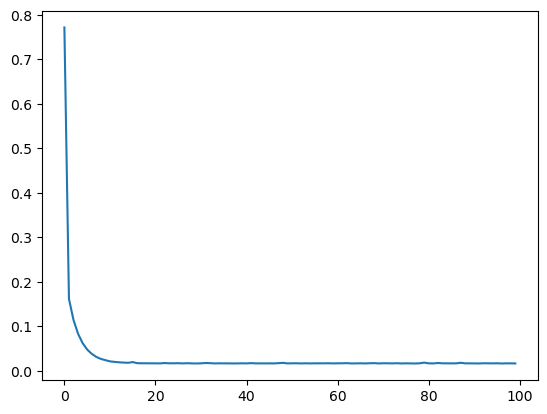

In [68]:
plt.plot(history.history['loss'])

Графiк з початковими даними та лiнiєю регресiї.

In [69]:
y_pred_test = model.predict(X_test, batch_size=32)
y_pred_train = model.predict(X_train, batch_size=32)

7/7 [==============================] - 0s 438us/step


/var/folders/88/94zrcllx065_b23pbtd8g1040000gn/T/ipykernel_25306/9715434.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


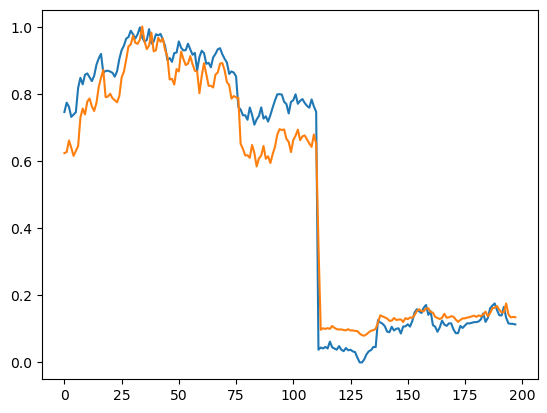

In [70]:
fig, ax = plt.subplots()
ax.plot(list(range(len(y_train))), y_train, list(range(len(y_train))), y_pred_train)
fig.show()

/var/folders/88/94zrcllx065_b23pbtd8g1040000gn/T/ipykernel_25306/2481641361.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


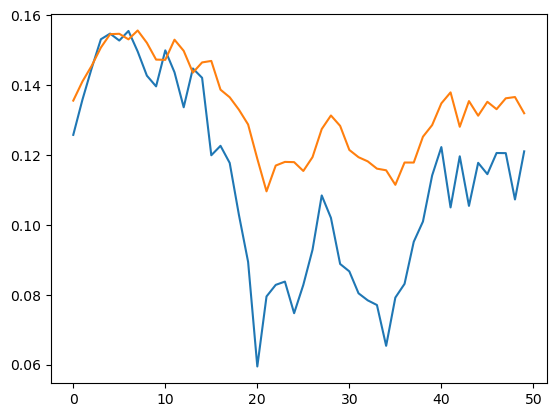

In [71]:
fig, ax = plt.subplots()
ax.plot(list(range(len(y_test))), y_test, list(range(len(y_test))), y_pred_test)
fig.show()